In [1]:
import torch
from torch import nn, optim
import numpy as np

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

with open('data/texts/anna.txt') as data:
    text = data.read()
    
len(text), text[:89]

(1985223,
 'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.')

In [3]:
vocab    = tuple(set(text))
int2char = dict(enumerate(vocab))
char2int = {char: i for i, char in int2char.items()}

In [4]:
# Integer encode text, and fit one-hot encoder for later use.
int_values = np.array([char2int[i] for i in text]).reshape(-1, 1)
encoder = OneHotEncoder(sparse=False).fit(int_values)

In [5]:
def train_val_split(arr, p=0.1):
    """split data according to desired percentate p"""
    split_idx = int(len(arr) * p)
    train_data = arr[:-split_idx]
    valid_data = arr[-split_idx:]
    return train_data, valid_data

def create_targets(sequence):
    """
    get sequence of shape (n_samples, n_features) and return
    target sequence of same shape with wrap-around where required.
    """
    wrap = sequence[0]
    return np.append(sequence[1:], wrap).reshape(sequence.shape)
    
t_x, v_x = train_val_split(int_values)

def get_batches(arr, batch_size, seq_length, encoder=None):
    """
    Divide 1 feature sequence data into batches. Each batch will contain
    `n=batch_size` sequences, each with length `m=seq_len`.
    """
 
    n_chars   = batch_size * seq_length          # -> Total # chars per batch
    n_batches = int(np.floor(len(arr)/ n_chars)) # -> Total batches possible 
    n_keep    = n_chars * n_batches              # -> Cutoff for even batches
    
    inputs  = arr[:n_keep]
    targets = create_targets(arr)[:n_keep]
    
    if encoder is not None:
        n_cats = len(encoder.categories_[0])
        inputs = encoder.transform(inputs.reshape(-1, 1))
        inputs = inputs.reshape(batch_size, -1, n_cats)
    else:
        inputs = inputs.reshape(batch_size, -1)
        
    targets = targets.reshape(batch_size, -1)
    
    for b in range(0, inputs.shape[1], seq_length): 
        x = torch.tensor(inputs[:, b: b + seq_length], dtype=torch.float32)
        y = torch.tensor(targets[:, b: b + seq_length], dtype=torch.float32)   
        yield x, y

In [6]:
# Test get_batches method on simple sequence
a = np.arange(10)
test_encoder = OneHotEncoder(sparse=False).fit(a.reshape(-1, 1))
batches = get_batches(a, 2, 2)
# batches = get_batches(a, 2, 2, encoder=test_encoder)

for x, y in batches:
    print(f'x: {x}')
    print(f'y: {y}\n')

x: tensor([[0., 1.],
        [4., 5.]])
y: tensor([[1., 2.],
        [5., 6.]])

x: tensor([[2., 3.],
        [6., 7.]])
y: tensor([[3., 4.],
        [7., 8.]])



In [12]:
class charNN(nn.Module):
    def __init__(self, vocab, hidden_size, n_layers, dropout=0.5):
        super().__init__()

        self.vocab_length = len(vocab)
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(self.vocab_length, hidden_size, n_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, self.vocab_length)
        self.do   = nn.Dropout(p=dropout)
        
    def forward(self, x, hidden=None):
        x, hidden = self.lstm(x, hidden)     # -> (n_batches, seq_len, hidden_size)
        x = self.do(x)
        x = x.reshape(-1, self.hidden_size)  # -> (n_batches * seq_len, hidden_size)
        x = self.fc(x)                       # -> (n_batches * seq_len, vocab_length)
        return x, hidden    
    
    def train_model(self, train_data, batch_size, 
                    seq_len, epochs, lr=0.01, clip=5, valid=None, encoder=None):
        
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self = self.to(device)
        
        opt = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        valid_loss = []
        train_loss = []
        
        for e in range(epochs):
            
            running_t_loss = 0
            running_v_loss = 0
            
            if valid is not None:
                v_hs = None
                self.eval()
                with torch.no_grad():
                    batches = get_batches(valid, batch_size, seq_len, encoder=encoder)
                    for x, y in batches:
                        x, y = x.to(device), y.to(device)
                        out, v_hs = self(x, v_hs)
                        loss = criterion(out, y.view(batch_size * seq_len).long())
                        running_v_loss += loss.item()
            
            self.train()
            hs = None
            batches = get_batches(t_x, 
                                  batch_size, 
                                  seq_len, 
                                  encoder=encoder)
            
            for x, y in batches:
                x, y = x.to(device), y.to(device)
                opt.zero_grad()
                out, hs = self(x, hs)
                hs = tuple([h_n.data for h_n in hs])
                loss = criterion(out, y.view(batch_size * seq_len).long())
                loss.backward()
                nn.utils.clip_grad_norm_(self.parameters(), clip)
                opt.step()
                running_t_loss += loss.item()
            
            train_loss.append(np.mean(running_t_loss))
            valid_loss.append(np.mean(running_v_loss))
            
            if e % np.floor(epochs / 10) == 0:
                print(f'------------ EPOCH {e} --------------')
                print(f'Training Loss: {train_loss[-1]}')
                print(f'Validation Loss: {valid_loss[-1]}')
        
        plt.plot(train_loss, label='Training Loss')
        plt.plot(valid_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.legend()
        plt.show()

In [13]:
n_hidden = 390
n_layers = 2

model = charNN(vocab, n_hidden, n_layers)
model = model.to(device)
model

charNN(
  (lstm): LSTM(83, 390, num_layers=2, batch_first=True)
  (fc): Linear(in_features=390, out_features=83, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)

------------ EPOCH 0 --------------
Training Loss: 363.56448888778687
Validation Loss: 66.17924308776855
------------ EPOCH 3 --------------
Training Loss: 183.05615603923798
Validation Loss: 21.231509566307068
------------ EPOCH 6 --------------
Training Loss: 166.28894209861755
Validation Loss: 19.685144662857056
------------ EPOCH 9 --------------
Training Loss: 159.1121221780777
Validation Loss: 19.4821994304657
------------ EPOCH 12 --------------
Training Loss: 154.70925557613373
Validation Loss: 19.329445481300354
------------ EPOCH 15 --------------
Training Loss: 151.78055369853973
Validation Loss: 19.287872433662415
------------ EPOCH 18 --------------
Training Loss: 149.6036684513092
Validation Loss: 19.291507363319397
------------ EPOCH 21 --------------
Training Loss: 147.65951371192932
Validation Loss: 19.307010173797607
------------ EPOCH 24 --------------
Training Loss: 145.97004687786102
Validation Loss: 19.501011729240417
------------ EPOCH 27 --------------
Training 

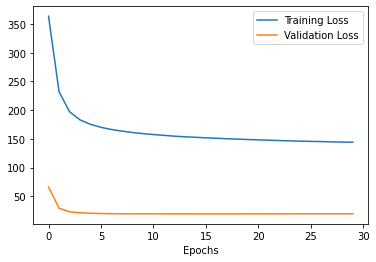

In [14]:
model.train_model(t_x, 128, 100, 30, valid=v_x, encoder=encoder)

In [18]:
saved_file = 'LSTM_30_epoch.net'

checkpoint = {
    'n_hidden': model.hidden_size,
    'n_layers': model.n_layers,
    'state_dict': model.state_dict(),
    'vocab': vocab
}

with open(f'saved/{saved_file}', 'wb') as f:
    torch.save(checkpoint, f)

AttributeError: 'charNN' object has no attribute 'n_layers'